In [16]:
import math
import copy
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.nn import TransformerDecoder, TransformerDecoderLayer
criterion = nn.MSELoss()

def all_step_error(outputs, labels):
    out = ((outputs-labels)**2)**0.5
    lossVal = torch.mean(out[:,:,0],dim=0)
    err_mean = torch.zeros([6])
    err_final = torch.zeros([6])
    for i in range(6):
        err_mean[i] = torch.mean(lossVal[:5*(i+1)])
        err_final[i] = lossVal[5*(i+1)-1]
    return err_mean, err_final

def step_error(outputs, labels):
    out = ((outputs-labels)**2)**0.5
    lossVal = torch.mean(out[:,:,0],dim=0)
    lossmean = torch.mean(lossVal)
    lossfinal = lossVal[-1]
    
    return lossmean, lossfinal

def subsequent_mask(size):
    """
    Mask out subsequent positions.
    """
    attn_shape = (1, size, size)
    mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(mask) == 0

def _generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()       
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        #pe.requires_grad = False
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]
def model_IDM(inputs_IDM, his_labels, output_length):
    v_pred = torch.zeros((inputs_IDM.shape[0], output_length, 1))
    y_pred = torch.zeros((inputs_IDM.shape[0], output_length, 1))
    acc = torch.zeros((inputs_IDM.shape[0], output_length, 1))
    y = inputs_IDM[:,0]
    v = inputs_IDM[:,1]
    s = inputs_IDM[:,2]
    delta_v = inputs_IDM[:,3]
        
    s_x = s_0+ torch.max(torch.tensor(0), v*T+((v*delta_v)/(2*(a*b)**0.5)))
    #s_x = torch.tensor(2.5)+ torch.max(torch.tensor(0), v*torch.tensor(1.25)+((v*delta_v)/(2*(torch.tensor(1.75)*torch.tensor(1.25))**0.5)))
    a_f = a*(1-(v/v_d)**4-(s_x/s)**2)
    #a_f = torch.tensor(1.75)*(1-(v/torch.tensor(30))**4-(s_x/s)**2)
    v_pred[:,0,0] = v+a_f*dt
    for i in range(len(v_pred)):
        if v_pred[i,0,0]<=0:
            v_pred[i,0,0]=0
    y_pred[:,0,0] = y+v_pred[i,0,0]*dt
    acc[:,0,0] = a_f
        
    for i in range(y_pred.shape[0]):
        for j in range(output_length-1):
            v = v_pred[i,j,0]
            delta_v = his_labels[i,j,1]-v_pred[i,j,0]
            s = his_labels[i,j,0]-y_pred[i,j,0]
            #s_x = self.s_0 + self.T*v - ((v * delta_v)/(2*(self.a*self.b)**0.5))
            #s_x = s_0 +  v*T-((v*delta_v)/(2*(a*b)**0.5))
            s_x = s_0 +  torch.max(torch.tensor(0), v*T+((v*delta_v)/(2*(a*b)**0.5)))
            #acc_temp = self.a*(1-(v/self.v_d)**4-(s_x/s)**2)
            acc_temp = a*(1-(v/v_d)**4-(s_x/s)**2)
            v2 = v + acc_temp * dt
            if v2<=0:
                v2 = 0
                acc_temp = (v2-v)/dt
            y1 = y_pred[i,j,0]
            y2 = y1 + v2 * dt
            acc[i,j+1,0] = acc_temp
            v_pred[i,j+1,0] = v2
            y_pred[i,j+1,0] = y2
                   
    return y_pred

class IDMModel(nn.Module):
    def __init__(self, s_0, T, a, b, v_d):
        super(IDMModel, self).__init__()
        self.model_type = 'IDM'
        self.dt=0.1
        self.s_0 = torch.tensor([1.667], requires_grad=True)
        self.T = torch.tensor([0.504], requires_grad=True)
        self.a = torch.tensor([0.430], requires_grad=True)
        self.b = torch.tensor([3.216], requires_grad=True)
        self.v_d = torch.tensor([16.775], requires_grad=True)
        
        self.s_0 = torch.nn.Parameter(self.s_0)
        self.T = torch.nn.Parameter(self.T)
        self.a = torch.nn.Parameter(self.a)
        self.b = torch.nn.Parameter(self.b)
        self.v_d = torch.nn.Parameter(self.v_d)
        
        self.s_0.data.fill_(s_0)
        self.T.data.fill_(T)
        self.a.data.fill_(a)
        self.b.data.fill_(b)
        self.v_d.data.fill_(v_d)
    def forward(self, inputs_IDM, his_labels):
        y = inputs_IDM[:,0]
        v = inputs_IDM[:,1]
        s = inputs_IDM[:,2]
        delta_v = inputs_IDM[:,3]
        
        s_x = self.s_0+  v*self.T+((v*delta_v)/(2*(self.a*self.b)**0.5))
        a_f = self.a*(1-(v/self.v_d)**4-(s_x/s)**2)
        v_pred = v+a_f*self.dt
        for i in range(len(v_pred)):
            if v_pred[i]<=0:
                v_pred[i]==0
        output_IDM = y+v_pred*self.dt
        return output_IDM.unsqueeze(1).unsqueeze(2), torch.Tensor(self.s_0.data.cpu().numpy()), torch.Tensor(self.T.data.cpu().numpy()), torch.Tensor(self.a.data.cpu().numpy()), torch.Tensor(self.b.data.cpu().numpy()), torch.Tensor(self.v_d.data.cpu().numpy())

class TransformerModel(nn.Module):
    def __init__(self, ninput, ntoken, ninp, nhead, nhid, fusion_size, nlayers, dropout):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        
        self.src_mask = None
        self.encoder_pos = PositionalEncoding(ninp)
        self.encoder_emb = nn.Linear(ninput, ninp)
        self.encoder_layer = TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        self.encoder = TransformerEncoder(self.encoder_layer, nlayers)
        self.decoder_emb = nn.Linear(ninput, ninp)
        self.decoder_layer = TransformerDecoderLayer(ninp, nhead, nhid, dropout)
        self.decoder = TransformerDecoder(self.decoder_layer, nlayers)
        self.output_layer = nn.Linear(ninp, ntoken)
        self.fusion_layer = nn.Linear(fusion_size, ntoken)
        self.init_weights()

        
    def init_weights(self):
        initrange = 0.1    
        self.encoder_emb.bias.data.zero_()
        self.encoder_emb.weight.data.uniform_(-initrange, initrange)
        self.decoder_emb.bias.data.zero_()
        self.decoder_emb.weight.data.uniform_(-initrange, initrange)
        self.output_layer.bias.data.zero_()
        self.output_layer.weight.data.uniform_(-initrange, initrange)
        self.fusion_layer.bias.data.zero_()
        self.fusion_layer.weight.data.uniform_(-initrange, initrange)

    def forward(self, src_inputs, dec_input, target_mask, his_labels):
        inputs = src_inputs[:,:,[0]]
        src = self.encoder_pos(self.encoder_emb(inputs.transpose(0,1)))
        memory = self.encoder(src)
        inp_decoder = self.decoder_emb(dec_input.transpose(0,1))
        out_decoder = self.decoder(inp_decoder, memory, target_mask)
        output = self.output_layer(out_decoder)
        output = output.transpose(0,1)
        dv = (inputs[:,-1,0]-inputs[:,-2,0])/1
        hist = torch.zeros(output.shape)
        for i in range(hist.shape[0]):
            hist[i,:,0] = torch.linspace(inputs[i,-1,0].item(), inputs[i,-1,0].item()+dv[i].item()*output.shape[1], output.shape[1]+1)[1:]
        out_length = output.shape[1]
        output_IDM = model_IDM(src_inputs[:,-1,:], his_labels[:,:out_length,:], out_length)
        fusion = torch.cat([output, hist, output_IDM], axis=2)
        final_output = self.fusion_layer(fusion)
        return final_output


In [17]:
class PINN(nn.Module):
    def __init__(self, s_0, T, a, b, v_d, ninput, ntoken, ninp, nhead, nhid, fusion_size, nlayers, dropout):
        super(PINN, self).__init__()
        self.dt = 0.1
        self.output_length = 30
        #self.s_0 = torch.tensor(s_0, requires_grad=True)
        #self.T = torch.tensor(T, requires_grad=True)
        #self.a = torch.tensor(a, requires_grad=True)
        #self.b = torch.tensor(b, requires_grad=True)
        #self.v_d = torch.tensor(v_d, requires_grad=True)
        
        #self.s_0 = torch.nn.Parameter(self.s_0)
        #self.T = torch.nn.Parameter(self.T)
        #self.a = torch.nn.Parameter(self.a)
        #self.b = torch.nn.Parameter(self.b)
        #self.v_d = torch.nn.Parameter(self.v_d)
        
        self.PUNN = TransformerModel(ninput, ntoken, ninp, nhead, nhid, fusion_size, nlayers, dropout)
        self.PINN = IDMModel(s_0, T, a, b, v_d)
        
        #self.Transformer.register_parameter('s_0', self.s_0)
        #self.Transformer.register_parameter('T', self.T)
        #self.Transformer.register_parameter('a', self.a)
        #self.Transformer.register_parameter('b', self.b)
        #self.Transformer.register_parameter('v_d', self.v_d)
        
        #self.optimizer = torch.optim.Adam(self.Transformer.parameters(), lr=0.00005)
        self.optimizer = torch.optim.Adam([{'params':self.PUNN.parameters(), 'lr':0.0005},{'params':self.PINN.parameters(),'lr':0.0000001}])
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, 15, gamma=0.1)
        #self.optimizer_PUNN = torch.optim.Adam(self.PUNN.parameters(), lr=0.0005)
        #self.scheduler_PUNN = torch.optim.lr_scheduler.StepLR(self.optimizer_PUNN, 15, gamma=0.1)
        #self.optimizer_PINN = torch.optim.Adam(self.PINN.parameters(), lr=0.0005)
        #self.scheduler_PINN = torch.optim.lr_scheduler.StepLR(self.optimizer_PINN, 15, gamma=0.1)
        #self.optimizer = torch.optim.Adam(self.Transformer.parameters())
        self.epoches = 30
        self.alpha = 0.7
        
    def net_PUNN(self, src_inputs, dec_input, target_mask, his_labels):
        output_trans = self.PUNN(src_inputs, dec_input, target_mask, his_labels)
        return output_trans
    
    def net_PINN(self, inputs_IDM, his_labels):
        output_IDM = self.PINN(inputs_IDM, his_labels)
        return output_IDM
    
    def PINN_without_grad(self, inputs_IDM, his_labels, s_0_item, T_item, a_item, b_item, vd_item):
        v_pred = torch.zeros((inputs_IDM.shape[0], self.output_length, 1))
        y_pred = torch.zeros((inputs_IDM.shape[0], self.output_length, 1))
        acc = torch.zeros((inputs_IDM.shape[0], self.output_length, 1))
        y = inputs_IDM[:,0]
        v = inputs_IDM[:,1]
        s = inputs_IDM[:,2]
        delta_v = inputs_IDM[:,3]
        
        #s_0_item = torch.Tensor(self.s_0.data.cpu().numpy())
        #T_item = torch.Tensor(self.T.data.cpu().numpy())
        #a_item = torch.Tensor(self.a.data.cpu().numpy())
        #b_item = torch.Tensor(self.b.data.cpu().numpy())
        #vd_item = torch.Tensor(self.v_d.data.cpu().numpy())
        s_x = s_0_item+ torch.max(torch.tensor(0), v*T_item+((v*delta_v)/(2*(a_item*b_item)**0.5)))
        #s_x = torch.tensor(2.5)+ torch.max(torch.tensor(0), v*torch.tensor(1.25)+((v*delta_v)/(2*(torch.tensor(1.75)*torch.tensor(1.25))**0.5)))
        a_f = a_item*(1-(v/vd_item)**4-(s_x/s)**2)
        #a_f = torch.tensor(1.75)*(1-(v/torch.tensor(30))**4-(s_x/s)**2)
        v_pred[:,0,0] = v+a_f*self.dt
        for i in range(len(v_pred)):
            if v_pred[i,0,0]<=0:
                v_pred[i,0,0]=0
        y_pred[:,0,0] = y+v_pred[i,0,0]*self.dt
        acc[:,0,0] = a_f
        
        for i in range(y_pred.shape[0]):
            for j in range(self.output_length-1):
                v = v_pred[i,j,0]
                delta_v = his_labels[i,j,1]-v_pred[i,j,0]
                s = his_labels[i,j,0]-y_pred[i,j,0]
                #s_x = self.s_0 + self.T*v - ((v * delta_v)/(2*(self.a*self.b)**0.5))
                s_x = s_0_item+  torch.max(torch.tensor(0),v*T_item+((v*delta_v)/(2*(a_item*b_item)**0.5)))
                #acc_temp = self.a*(1-(v/self.v_d)**4-(s_x/s)**2)
                acc_temp = a_item*(1-(v/vd_item)**4-(s_x/s)**2)
                v2 = v + acc_temp * self.dt
                if v2 <= 0:
                    v2 = 0
                    acc_temp = (v2-v)/self.dt
                y1 = y_pred[i,j,0]
                y2 = y1 + v2 * self.dt
                acc[i,j+1,0] = acc_temp
                v_pred[i,j+1,0] = v2
                y_pred[i,j+1,0] = y2
        return y_pred
    
    def train(self):
        #the training part has been deleted because of the confidentiality agreement
        
    def predict(self, inputs, dec_input, target_mask, his_labels, model_location):
        #self.Transformer = TransformerModel(ntokens, ninp, nhead, nhid, nlayers, dropout, fusion_size)
        self.PUNN.load_state_dict(torch.load(model_location))
        #self.Transformer = model
        self.PUNN.eval()
        out_Trans = self.net_PUNN(inputs, dec_input, target_mask, his_labels)
        #out_IDM = self.net_IDM(inputs[:,-1,:], labels)
        return out_Trans


In [18]:
s_0 = 1.667/(max_num-min_num)
T = 0.504
a = 0.430/(max_num-min_num)
b = 3.216/(max_num-min_num)
v_d = 16.775/(max_num-min_num)

ntoken = 1 # the size of outputs
ninput = 1
ninp = 50 # embedding dimension
nhid = 50 # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2 # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 10 # the number of heads in the multiheadattention models
fusion_size = 3
dropout = 0.1 # the dropout value
dt = 0.1
output_length = 30

PIT_IDM = PINN(s_0, T, a, b, v_d, ninput, ntoken, ninp, nhead, nhid, fusion_size, nlayers, dropout)
model_location = r'\PIT-IDM(2)_UTE.tar'

In [3]:
import pandas as pd
import numpy as np

all_pd_1 = pd.read_csv(r'\UTE_CKQ4_up.csv', delimiter=',', skiprows=0)
all_pd_2 = pd.read_csv(r'\UTE_CKQ4_down.csv', delimiter=',', skiprows=0)

all_pd_data_1 = all_pd_1[['Vehicle_ID', 'Frame_ID', 'y', 'Pre_y', 'v', 'Spacing', 'delta_v', 'Preceding', 'Direction', 'Pre_v']]
all_pd_data_2 = all_pd_2[['Vehicle_ID', 'Frame_ID', 'y', 'Pre_y', 'v', 'Spacing', 'delta_v', 'Preceding', 'Direction', 'Pre_v']]
all_pd_data = pd.concat([all_pd_data_1, all_pd_data_2], axis=0).reset_index()
all_pd_data = all_pd_data.drop(columns=['index'])

pro_data = all_pd_data.to_numpy()

all_input=[]
for i in range(int(0.8*pro_data.shape[0])-2*50):
    if pro_data[i, 0] == pro_data[i + 49, 0] and pro_data[i, 7] == pro_data[i + 49, 7] and pro_data[i + 49, 1] - pro_data[
        i, 1] == 49*1 and pro_data[i + 49, 0] == pro_data[i + 79, 0] and pro_data[i + 79, 7] == pro_data[i + 49, 7] and pro_data[i + 79, 1] - \
            pro_data[i + 49, 1] == 30*1:
        no_use = pro_data[i + 50:i + 2 * 50]
        no_use = np.array(no_use)
        the_output = no_use[:, :]
        all_together = np.hstack((pro_data[i: i + 50][:, :], the_output))
        all_input.append(all_together)

x_train = []
y_train = []
train_labels = []
for i in range(len(all_input)):
    temp = all_input[i]
    temp_y = temp[:30,12]-temp[0,2]
    temp_y_pre = temp[:30,13]-temp[0,2]
    temp_yv_pre = temp[:30,-1]
    #temp_a = temp[:30,-1]
    begin_pos = temp[0,2]
    temp[:,2] = temp[:,2] - begin_pos
    temp[:,3] = temp[:,3] - begin_pos
    temp[1:,2] = temp[1:,2]*temp[0,8]
    temp[:,3] = temp[:,3]*temp[0,8]
    temp_y = temp_y*temp[0,8]
    temp_y_pre = temp_y_pre*temp[0,8]
    if temp_y[0]<=temp[-1,2] or temp_y[0]<=0 or temp_y[0]>=temp_y_pre[0]:
        continue
    y_train.append([temp_y])
    train_labels.append([temp_y_pre, temp_yv_pre])
    x_train.append(temp[:,[2,4,5,6]])

all_input=[]
for i in range(int(pro_data.shape[0]*0.8), int(pro_data.shape[0]*0.9)-2*50):
    if pro_data[i, 0] == pro_data[i + 49, 0] and pro_data[i, 7] == pro_data[i + 49, 7] and pro_data[i + 49, 1] - pro_data[
        i, 1] == 49*1 and pro_data[i + 49, 0] == pro_data[i + 79, 0] and pro_data[i + 79, 7] == pro_data[i + 49, 7] and pro_data[i + 79, 1] - \
            pro_data[i + 49, 1] == 30*1:
        no_use = pro_data[i + 50:i + 2 * 50]
        no_use = np.array(no_use)
        the_output = no_use[:, :]
        all_together = np.hstack((pro_data[i: i + 50][:, :], the_output))
        all_input.append(all_together)

x_test = []
y_test = []
test_labels = []
for i in range(len(all_input)):
    temp = all_input[i]
    temp_y = temp[:30,12]-temp[0,2]
    temp_y_pre = temp[:30,13]-temp[0,2]
    temp_yv_pre = temp[:30,-1]
    #temp_a = temp[:30,-1]
    begin_pos = temp[0,2]
    temp[:,2] = temp[:,2] - begin_pos
    temp[:,3] = temp[:,3] - begin_pos
    temp[1:,2] = temp[1:,2]*temp[0,8]
    temp[:,3] = temp[:,3]*temp[0,8]
    temp_y = temp_y*temp[0,8]
    temp_y_pre = temp_y_pre*temp[0,8]
    if temp_y[0]<=temp[-1,2] or temp_y[0]<=0 or temp_y[0]>=temp_y_pre[0]:
        continue
    y_test.append([temp_y])
    test_labels.append([temp_y_pre, temp_yv_pre])
    x_test.append(temp[:,[2,4,5,6]])

all_input=[]
for i in range(int(pro_data.shape[0]*0.9), int(pro_data.shape[0])-2*50):
    if pro_data[i, 0] == pro_data[i + 49, 0] and pro_data[i, 7] == pro_data[i + 49, 7] and pro_data[i + 49, 1] - pro_data[
        i, 1] == 49*1 and pro_data[i + 49, 0] == pro_data[i + 79, 0] and pro_data[i + 79, 7] == pro_data[i + 49, 7] and pro_data[i + 79, 1] - \
            pro_data[i + 49, 1] == 30*1:
        no_use = pro_data[i + 50:i + 2 * 50]
        no_use = np.array(no_use)
        the_output = no_use[:, :]
        all_together = np.hstack((pro_data[i: i + 50][:, :], the_output))
        all_input.append(all_together)

x_val = []
y_val = []
val_labels = []
for i in range(len(all_input)):
    temp = all_input[i]
    temp_y = temp[:30,12]-temp[0,2]
    temp_y_pre = temp[:30,13]-temp[0,2]
    temp_yv_pre = temp[:30,-1]
    #temp_a = temp[:30,-1]
    begin_pos = temp[0,2]
    temp[:,2] = temp[:,2] - begin_pos
    temp[:,3] = temp[:,3] - begin_pos
    temp[1:,2] = temp[1:,2]*temp[0,8]
    temp[:,3] = temp[:,3]*temp[0,8]
    temp_y = temp_y*temp[0,8]
    temp_y_pre = temp_y_pre*temp[0,8]
    if temp_y[0]<=temp[-1,2] or temp_y[0]<=0 or temp_y[0]>=temp_y_pre[0]:
        continue
    y_val.append([temp_y])
    val_labels.append([temp_y_pre, temp_yv_pre])
    x_val.append(temp[:,[2,4,5,6]])

x_train = np.array(x_train)
y_train = np.array(y_train)
train_labels = np.array(train_labels)
y_train = y_train.transpose(0,2,1)
train_labels = train_labels.transpose(0,2,1)

x_test = np.array(x_test)
y_test = np.array(y_test)
test_labels = np.array(test_labels)
y_test = y_test.transpose(0,2,1)
test_labels = test_labels.transpose(0,2,1)

x_val = np.array(x_val)
y_val = np.array(y_val)
val_labels = np.array(val_labels)
y_val = y_val.transpose(0,2,1)
val_labels = val_labels.transpose(0,2,1)

max_num = max([np.max(x_train[:,:,0]),np.max(y_train[:,:,0]),np.max(x_test[:,:,0]),np.max(y_test[:,:,0]),np.max(x_val[:,:,0]),np.max(y_val[:,:,0])])
min_num = min([np.min(x_train[:,:,0]),np.min(y_train[:,:,0]),np.min(x_test[:,:,0]),np.min(y_test[:,:,0]),np.min(x_val[:,:,0]),np.min(y_val[:,:,0])])

x_train[:,:,[0]] = x_train[:,:,[0]]-min_num
y_train[:,:,[0]] = y_train[:,:,[0]]-min_num
train_labels[:,:,[0]] = train_labels[:,:,[0]]-min_num
x_test[:,:,[0]] = x_test[:,:,[0]]-min_num
y_test[:,:,[0]] = y_test[:,:,[0]]-min_num
test_labels[:,:,[0]] = test_labels[:,:,[0]]-min_num
x_val[:,:,[0]] = x_val[:,:,[0]]-min_num
y_val[:,:,[0]] = y_val[:,:,[0]]-min_num
val_labels[:,:,[0]] = val_labels[:,:,[0]]-min_num

x_train = x_train/(max_num-min_num)
y_train = y_train/(max_num-min_num)
train_labels = train_labels/(max_num-min_num)
x_test = x_test/(max_num-min_num)
y_test = y_test/(max_num-min_num)
test_labels = test_labels/(max_num-min_num)
x_val = x_val/(max_num-min_num)
y_val = y_val/(max_num-min_num)
val_labels = val_labels/(max_num-min_num)

In [4]:
dt = 0.1
all_input=[]
for i in range(int(pro_data.shape[0]*0.8), int(pro_data.shape[0]*0.9)-2*50):
    if pro_data[i, 0] == pro_data[i + 49, 0] and pro_data[i, 7] == pro_data[i + 49, 7] and pro_data[i + 49, 1] - pro_data[
        i, 1] == 49*1 and pro_data[i + 49, 0] == pro_data[i + 79, 0] and pro_data[i + 79, 7] == pro_data[i + 49, 7] and pro_data[i + 79, 1] - \
            pro_data[i + 49, 1] == 30*1:
        no_use = pro_data[i + 50:i + 2 * 50]
        no_use = np.array(no_use)
        the_output = no_use[:, :]
        all_together = np.hstack((pro_data[i: i + 50][:, :], the_output))
        all_input.append(all_together)

x_test = []
y_test = []
test_labels = []
test_pre_labels = []
begin_positions = []
for i in range(len(all_input)):
    temp = all_input[i]
    temp_y = temp[:30,12]-temp[0,2]
    temp_y_pre = temp[:30,13]-temp[0,2]
    temp_yv_pre = temp[:30,-1]
    #temp_a = temp[:30,-1]
    begin_pos = temp[0,2]
    temp[:,2] = temp[:,2] - begin_pos
    temp[:,3] = temp[:,3] - begin_pos
    temp[1:,2] = temp[1:,2]*temp[0,8]
    temp[:,3] = temp[:,3]*temp[0,8]
    temp_y = temp_y*temp[0,8]
    temp_y_pre = temp_y_pre*temp[0,8]
    if temp_y[0]<=temp[-1,2] or temp_y[0]<=0 or temp_y[0]>=temp_y_pre[0]:
        continue
    yv_pre = temp[-1, 9]
    y_pre = temp[-1, 3]
    if yv_pre != 0:
        test_yv_pre = yv_pre*np.ones(30)
        test_y_pre = np.linspace(y_pre, y_pre+yv_pre*30*dt,31)[1:]
    else:
        test_yv_pre = np.zeros(30)
        test_y_pre = np.linspace(y_pre, y_pre+temp[-1,4]*30*dt,31)[1:]
    y_test.append([temp_y])
    test_labels.append([temp_y_pre, temp_yv_pre])
    x_test.append(temp[:,[2,4,5,6]])
    test_pre_labels.append([test_y_pre, test_yv_pre])
    begin_positions.append(begin_pos)

x_test = np.array(x_test)
y_test = np.array(y_test)
test_labels = np.array(test_labels)
test_pre_labels = np.array(test_pre_labels)
y_test = y_test.transpose(0,2,1)
test_labels = test_labels.transpose(0,2,1)
test_pre_labels = test_pre_labels.transpose(0,2,1)

x_test[:,:,[0]] = x_test[:,:,[0]]-min_num
y_test[:,:,[0]] = y_test[:,:,[0]]-min_num
test_labels[:,:,[0]] = test_labels[:,:,[0]]-min_num
test_pre_labels[:,:,[0]] = test_pre_labels[:,:,[0]]-min_num

x_test = x_test/(max_num-min_num)
y_test = y_test/(max_num-min_num)
test_labels = test_labels/(max_num-min_num)
test_pre_labels = test_pre_labels/(max_num-min_num)

In [5]:
print(x_test.shape, y_test.shape, test_pre_labels.shape, len(begin_positions))

(13967, 50, 4) (13967, 30, 1) (13967, 30, 2) 13967


In [10]:
import copy
import torch
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
from multi_attention_forward import multi_head_attention_forward

def _get_activation_fn(activation):
    if activation == "relu":
        return F.relu
    elif activation == "gelu":
        return F.gelu
    else:
        raise RuntimeError("activation should be relu/gelu, not %s." % activation)

def _get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

def subsequent_mask(size):
    """
    Mask out subsequent positions.
    """
    attn_shape = (1, size, size)
    mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(mask) == 0

def _generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()       
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        #pe.requires_grad = False
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

class MultiheadAttention(nn.Module):
    r"""Allows the model to jointly attend to information
    from different representation subspaces.
    See reference: Attention Is All You Need
    .. math::
        \text{MultiHead}(Q, K, V) = \text{Concat}(head_1,\dots,head_h)W^O
        \text{where} head_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V)
    Args:
        embed_dim: total dimension of the model.
        num_heads: parallel attention heads.
        dropout: a Dropout layer on attn_output_weights. Default: 0.0.
        bias: add bias as module parameter. Default: True.
        add_bias_kv: add bias to the key and value sequences at dim=0.
        add_zero_attn: add a new batch of zeros to the key and
                       value sequences at dim=1.
        kdim: total number of features in key. Default: None.
        vdim: total number of features in key. Default: None.
        Note: if kdim and vdim are None, they will be set to embed_dim such that
        query, key, and value have the same number of features.
    Examples::
        >>> multihead_attn = nn.MultiheadAttention(embed_dim, num_heads)
        >>> attn_output, attn_output_weights = multihead_attn(query, key, value)
    """
    __constants__ = ['q_proj_weight', 'k_proj_weight', 'v_proj_weight', 'in_proj_weight']

    def __init__(self, embed_dim, num_heads, dropout=0., bias=True, add_bias_kv=False, add_zero_attn=False, kdim=None,
                 vdim=None):
        super(MultiheadAttention, self).__init__()
        self.embed_dim = embed_dim
        self.kdim = kdim if kdim is not None else embed_dim
        self.vdim = vdim if vdim is not None else embed_dim
        self._qkv_same_embed_dim = self.kdim == embed_dim and self.vdim == embed_dim

        self.num_heads = num_heads
        self.dropout = dropout
        self.head_dim = embed_dim // num_heads
        assert self.head_dim * num_heads == self.embed_dim, "embed_dim must be divisible by num_heads"

        if self._qkv_same_embed_dim is False:
            self.q_proj_weight = nn.Parameter(torch.Tensor(embed_dim, embed_dim))
            self.k_proj_weight = nn.Parameter(torch.Tensor(embed_dim, self.kdim))
            self.v_proj_weight = nn.Parameter(torch.Tensor(embed_dim, self.vdim))
            self.register_parameter('in_proj_weight', None)
        else:
            self.in_proj_weight = nn.Parameter(torch.empty(3 * embed_dim, embed_dim))
            self.register_parameter('q_proj_weight', None)
            self.register_parameter('k_proj_weight', None)
            self.register_parameter('v_proj_weight', None)

        if bias:
            self.in_proj_bias = nn.Parameter(torch.empty(3 * embed_dim))
        else:
            self.register_parameter('in_proj_bias', None)
        self.out_proj = nn.Linear(embed_dim, embed_dim, bias=bias)

        if add_bias_kv:
            self.bias_k = nn.Parameter(torch.empty(1, 1, embed_dim))
            self.bias_v = nn.Parameter(torch.empty(1, 1, embed_dim))
        else:
            self.bias_k = self.bias_v = None

        self.add_zero_attn = add_zero_attn

        self._reset_parameters()

    def _reset_parameters(self):
        if self._qkv_same_embed_dim:
            nn.init.xavier_uniform_(self.in_proj_weight)
        else:
            nn.init.xavier_uniform_(self.q_proj_weight)
            nn.init.xavier_uniform_(self.k_proj_weight)
            nn.init.xavier_uniform_(self.v_proj_weight)

        if self.in_proj_bias is not None:
            nn.init.constant_(self.in_proj_bias, 0.)
            nn.init.constant_(self.out_proj.bias, 0.)
        if self.bias_k is not None:
            nn.init.xavier_normal_(self.bias_k)
        if self.bias_v is not None:
            nn.init.xavier_normal_(self.bias_v)

    def __setstate__(self, state):
        # Support loading old MultiheadAttention checkpoints generated by v1.1.0
        if '_qkv_same_embed_dim' not in state:
            state['_qkv_same_embed_dim'] = True

        super(MultiheadAttention, self).__setstate__(state)

    def forward(self, query, key, value, key_padding_mask=None,
                need_weights=True, attn_mask=None):
        # type: (Tensor, Tensor, Tensor, Optional[Tensor], bool, Optional[Tensor]) -> Tuple[Tensor, Optional[Tensor]]
        r"""
    Args:
        query, key, value: map a query and a set of key-value pairs to an output.
            See "Attention Is All You Need" for more details.
        key_padding_mask: if provided, specified padding elements in the key will
            be ignored by the attention. This is an binary mask. When the value is True,
            the corresponding value on the attention layer will be filled with -inf.
        need_weights: output attn_output_weights.
        attn_mask: mask that prevents attention to certain positions. This is an additive mask
            (i.e. the values will be added to the attention layer).
    Shape:
        - Inputs:
        - query: :math:`(L, N, E)` where L is the target sequence length, N is the batch size, E is
          the embedding dimension.
        - key: :math:`(S, N, E)`, where S is the source sequence length, N is the batch size, E is
          the embedding dimension.
        - value: :math:`(S, N, E)` where S is the source sequence length, N is the batch size, E is
          the embedding dimension.
        - key_padding_mask: :math:`(N, S)`, ByteTensor, where N is the batch size, S is the source sequence length.
        - attn_mask: :math:`(L, S)` where L is the target sequence length, S is the source sequence length.
        - Outputs:
        - attn_output: :math:`(L, N, E)` where L is the target sequence length, N is the batch size,
          E is the embedding dimension.
        - attn_output_weights: :math:`(N, L, S)` where N is the batch size,
          L is the target sequence length, S is the source sequence length.
        """
        if not self._qkv_same_embed_dim:
            return multi_head_attention_forward(
                query, key, value, self.embed_dim, self.num_heads,
                self.in_proj_weight, self.in_proj_bias,
                self.bias_k, self.bias_v, self.add_zero_attn,
                self.dropout, self.out_proj.weight, self.out_proj.bias,
                training=self.training,
                key_padding_mask=key_padding_mask, need_weights=need_weights,
                attn_mask=attn_mask, use_separate_proj_weight=True,
                q_proj_weight=self.q_proj_weight, k_proj_weight=self.k_proj_weight,
                v_proj_weight=self.v_proj_weight)
        else:
            return multi_head_attention_forward(
                query, key, value, self.embed_dim, self.num_heads,
                self.in_proj_weight, self.in_proj_bias,
                self.bias_k, self.bias_v, self.add_zero_attn,
                self.dropout, self.out_proj.weight, self.out_proj.bias,
                training=self.training,
                key_padding_mask=key_padding_mask, need_weights=need_weights,
                attn_mask=attn_mask)


class TransformerEncoderLayer(nn.Module):

    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0, activation="relu"):
        super(TransformerEncoderLayer, self).__init__()
        self.self_attn = MultiheadAttention(d_model, nhead, dropout=dropout)
        # Implementation of Feedforward model
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

        self.activation = _get_activation_fn(activation)

    def forward(self, src, src_mask=None, src_key_padding_mask=None):
        r"""Pass the input through the encoder layer.

        Args:
            src: the sequnce to the encoder layer (required).
            src_mask: the mask for the src sequence (optional).
            src_key_padding_mask: the mask for the src keys per batch (optional).

        Shape:
            see the docs in Transformer class.
        """
        src2, attn = self.self_attn(src, src, src, attn_mask=src_mask,
                                    key_padding_mask=src_key_padding_mask)
        src = src + self.dropout1(src2)
        src = self.norm1(src)

        if hasattr(self, "activation"):
            src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        else:  # for backward compatibility
            src2 = self.linear2(self.dropout(F.relu(self.linear1(src))))

        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src, attn


class TransformerEncoder(nn.Module):
    r"""TransformerEncoder is a stack of N encoder layers

    Args:
        encoder_layer: an instance of the TransformerEncoderLayer() class (required).
        num_layers: the number of sub-encoder-layers in the encoder (required).
        norm: the layer normalization component (optional).

    Examples::
        >>> encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8)
        >>> transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=6)
        >>> src = torch.rand(10, 32, 512)
        >>> out = transformer_encoder(src)
    """

    def __init__(self, encoder_layer, num_layers, norm=None):
        super(TransformerEncoder, self).__init__()
        self.layers = _get_clones(encoder_layer, num_layers)
        self.num_layers = num_layers
        self.norm = norm

    def forward(self, src, mask=None, src_key_padding_mask=None):
        r"""Pass the input through the encoder layers in turn.

        Args:
            src: the sequnce to the encoder (required).
            mask: the mask for the src sequence (optional).
            src_key_padding_mask: the mask for the src keys per batch (optional).

        Shape:
            see the docs in Transformer class.
        """
        output = src

        atts = []

        for i in range(self.num_layers):
            output, attn = self.layers[i](output, src_mask=mask,
                                          src_key_padding_mask=src_key_padding_mask)
            atts.append(attn)
        if self.norm:
            output = self.norm(output)

        return output, atts

class TransformerDecoderLayer(nn.Module):

    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0, activation="relu"):
        super(TransformerDecoderLayer, self).__init__()
        self.tgt_attn = MultiheadAttention(d_model, nhead, dropout=dropout)
        self.src_attn = MultiheadAttention(d_model, nhead, dropout=dropout)
        # Implementation of Feedforward model
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

        self.activation = _get_activation_fn(activation)

    def forward(self, src, target, src_mask=None, target_mask=None, src_key_padding_mask=None):
        r"""Pass the input through the encoder layer.

        Args:
            src: the sequnce to the encoder layer (required).
            src_mask: the mask for the src sequence (optional).
            src_key_padding_mask: the mask for the src keys per batch (optional).

        Shape:
            see the docs in Transformer class.
        """
        target2, attn_tgt = self.tgt_attn(target, target, target, attn_mask=target_mask,
                                    key_padding_mask=src_key_padding_mask)
        target = target+self.dropout1(target2)
        target = self.norm1(target)
        
        target2, attn_src = self.src_attn(target, src, src, attn_mask=src_mask,
                                    key_padding_mask=src_key_padding_mask)
        target = target + self.dropout2(target2)
        target = self.norm2(target)

        if hasattr(self, "activation"):
            target2 = self.linear2(self.dropout(self.activation(self.linear1(target))))
        else:  # for backward compatibility
            target2 = self.linear2(self.dropout(F.relu(self.linear1(target))))

        target = target + self.dropout3(target2)
        target = self.norm3(target)
        return target, attn_tgt, attn_src
    
class TransformerDecoder(nn.Module):
    r"""TransformerEncoder is a stack of N encoder layers

    Args:
        encoder_layer: an instance of the TransformerEncoderLayer() class (required).
        num_layers: the number of sub-encoder-layers in the encoder (required).
        norm: the layer normalization component (optional).

    Examples::
        >>> encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8)
        >>> transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=6)
        >>> src = torch.rand(10, 32, 512)
        >>> out = transformer_encoder(src)
    """

    def __init__(self, decoder_layer, num_layers, norm=None):
        super(TransformerDecoder, self).__init__()
        self.layers = _get_clones(decoder_layer, num_layers)
        self.num_layers = num_layers
        self.norm = norm

    def forward(self, src, target, src_mask=None, target_mask=None, src_key_padding_mask=None):
        r"""Pass the input through the encoder layers in turn.

        Args:
            src: the sequnce to the encoder (required).
            mask: the mask for the src sequence (optional).
            src_key_padding_mask: the mask for the src keys per batch (optional).

        Shape:
            see the docs in Transformer class.
        """

        atts_tgt = []
        atts_src = []

        for i in range(self.num_layers):
            target, attn_tgt, attn_src = self.layers[i](src, target, src_mask=src_mask,target_mask = target_mask,
                                          src_key_padding_mask=src_key_padding_mask)
            atts_tgt.append(attn_tgt)
            atts_src.append(attn_src)
        if self.norm:
            target = self.norm(target)

        return target, atts_tgt, atts_src

class TransformerModel(nn.Module):
    def __init__(self, ninput, ntoken, ninp, nhead, nhid, nlayers, dropout):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        
        self.src_mask = None
        self.encoder_pos = PositionalEncoding(ninp)
        self.encoder_emb = nn.Linear(ninput, ninp)
        self.encoder_layer = TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        self.encoder = TransformerEncoder(self.encoder_layer, nlayers)
        self.decoder_emb = nn.Linear(ninput, ninp)
        self.decoder_layer = TransformerDecoderLayer(ninp, nhead, nhid, dropout)
        self.decoder = TransformerDecoder(self.decoder_layer, nlayers)
        self.output_layer = nn.Linear(ninp, ntoken)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1    
        self.encoder_emb.bias.data.zero_()
        self.encoder_emb.weight.data.uniform_(-initrange, initrange)
        self.decoder_emb.bias.data.zero_()
        self.decoder_emb.weight.data.uniform_(-initrange, initrange)
        self.output_layer.bias.data.zero_()
        self.output_layer.weight.data.uniform_(-initrange, initrange)

    def forward(self, inputs, dec_input, target_mask):
        #inputs = src_inputs[:,:,[0]]
        src = self.encoder_pos(self.encoder_emb(inputs.transpose(0,1)))
        memory, attention_enc = self.encoder(src)
        inp_decoder = self.decoder_emb(dec_input.transpose(0,1))
        out_decoder, attention_tgt, attention_src = self.decoder(src=memory, target=inp_decoder, src_mask=None, target_mask=target_mask)
        output = self.output_layer(out_decoder)
        output = output.transpose(0,1)
        return output, attention_enc, attention_tgt, attention_src

ninp = 50
ninput = 1
ntoken = 1
nhid = 50
nhead = 10
dropout = 0.1
nlayers = 2
Trans_model = TransformerModel(ninput, ntoken, ninp, nhead, nhid, nlayers, dropout)
Trans_model_location = r'\Transformer_UTE.tar'
Trans_model.load_state_dict(torch.load(Trans_model_location))

<All keys matched successfully>

In [11]:
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [12]:
x_test.shape

(13967, 50, 4)

In [13]:
a_item = 2.681
b_item = 5.485
v_d_item = 34.569
s_0_item = 5.872
T_item = 1.191
dt = 0.1
def model_IDM_test(inputs_IDM, his_labels, output_length):
    v_pred = torch.zeros((inputs_IDM.shape[0], output_length, 1))
    y_pred = torch.zeros((inputs_IDM.shape[0], output_length, 1))
    acc = torch.zeros((inputs_IDM.shape[0], output_length, 1))
    y = inputs_IDM[:,0]
    v = inputs_IDM[:,1]
    s = inputs_IDM[:,2]
    delta_v = inputs_IDM[:,3]
    
    s_x = s_0_item + torch.max(torch.tensor(0), v*T_item+((v*delta_v)/(2*(a_item*b_item)**0.5)))
    #s_x = torch.tensor(2.5)+ torch.max(torch.tensor(0), v*torch.tensor(1.25)+((v*delta_v)/(2*(torch.tensor(1.75)*torch.tensor(1.25))**0.5)))
    a_f = a_item*(1-(v/v_d_item)**4-(s_x/s)**2)
    #a_f = torch.tensor(1.75)*(1-(v/torch.tensor(30))**4-(s_x/s)**2)
    v_pred[:,0,0] = v+a_f*dt
    for i in range(len(v_pred)):
        if v_pred[i,0,0]<=0:
            v_pred[i,0,0]=0
    y_pred[:,0,0] = y+v_pred[i,0,0]*dt
    acc[:,0,0] = a_f
        
    for i in range(y_pred.shape[0]):
        for j in range(output_length-1):
            v = v_pred[i,j,0]
            delta_v = his_labels[i,j,1]-v_pred[i,j,0]
            s = his_labels[i,j,0]-y_pred[i,j,0]
            #s_x = self.s_0 + self.T*v - ((v * delta_v)/(2*(self.a*self.b)**0.5))
            #s_x = s_0 +  v*T-((v*delta_v)/(2*(a*b)**0.5))
            s_x = s_0_item +  torch.max(torch.tensor(0), v*T_item+((v*delta_v)/(2*(a_item*b_item)**0.5)))
            #acc_temp = self.a*(1-(v/self.v_d)**4-(s_x/s)**2)
            acc_temp = a_item*(1-(v/v_d_item)**4-(s_x/s)**2)
            v2 = v + acc_temp * dt
            if v2<=0:
                v2 = 0
                acc_temp = (v2-v)/dt
            y1 = y_pred[i,j,0]
            y2 = y1 + v2 * dt
            acc[i,j+1,0] = acc_temp
            v_pred[i,j+1,0] = v2
            y_pred[i,j+1,0] = y2
                   
    return y_pred


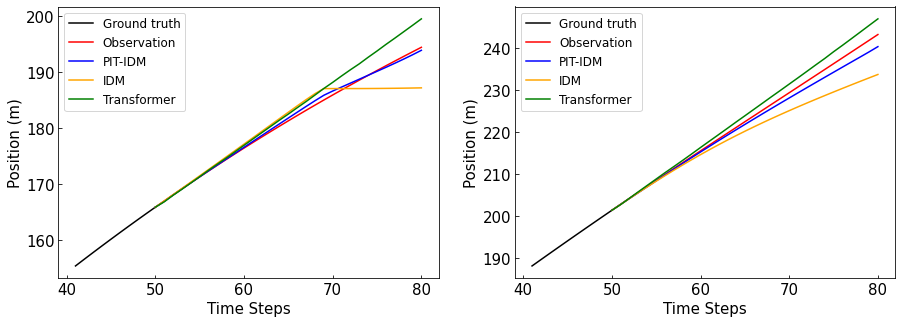

In [22]:
fig, (ax1,ax2)=plt.subplots(1,2,figsize=(15,5))

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

i = 32
inputs = torch.from_numpy(x_test[20*i+5,:,:]).unsqueeze(0).to(torch.float32)
hist_labels = torch.from_numpy(test_pre_labels[20*i+5,:,:]).unsqueeze(0).to(torch.float32)
labels = torch.from_numpy(y_test[20*i+5,:,:]).unsqueeze(0).to(torch.float32)

inputs_trans = inputs[:,:,[0]]
start_of_seq = torch.Tensor([0]).unsqueeze(0).unsqueeze(1).repeat(labels.shape[0],1,1)
dec_input = start_of_seq
for j in range(output_length):
    target_mask = _generate_square_subsequent_mask(dec_input.shape[1])
    output_trans,_,_,_ = Trans_model(inputs_trans, dec_input, target_mask)
    dec_input = torch.cat((dec_input, output_trans[:,-1:,:]),1)
outputs_trans = dec_input[:,1:,:]

start_of_seq = torch.Tensor([0]).unsqueeze(0).unsqueeze(1).repeat(labels.shape[0],1,1)
dec_input = start_of_seq
for j in range(output_length):
    target_mask = _generate_square_subsequent_mask(dec_input.shape[1])
    outputs = PIT_IDM.predict(inputs, dec_input, target_mask, hist_labels, model_location)
    dec_input = torch.cat((dec_input, outputs[:,-1:,:]),1)
outputs = dec_input[:,1:,:]

outputs_IDM = model_IDM(inputs[:,-1,:], hist_labels[:,:,:], output_length)
y_label = labels[0,:,0].detach().numpy()*(max_num-min_num)
y_output = outputs[0,:,0].detach().numpy()*(max_num-min_num)
y_output_IDM = outputs_IDM[0,:,0].detach().numpy()*(max_num-min_num)
y_output_trans = outputs_trans[0,:,0].detach().numpy()*(max_num-min_num)
x_pred = np.arange(1,32)+49
x_obs = np.arange(1,51)
y_obs = inputs[0,:,0].detach().numpy()*(max_num-min_num)
y_label = np.concatenate((np.array([y_obs[-1]]),y_label))
y_output= np.concatenate((np.array([y_obs[-1]]),y_output))
y_output_IDM = np.concatenate((np.array([y_obs[-1]]),y_output_IDM))
y_output_trans = np.concatenate((np.array([y_obs[-1]]),y_output_trans))

ax1.plot(x_obs[40:], (y_obs[40:]+min_num+begin_positions[40*i+17]), color='black', label='Ground truth')
ax1.plot(x_pred, (y_label+min_num+begin_positions[40*i+17]), color='red', label='Observation')
ax1.plot(x_pred, (y_output+min_num+begin_positions[40*i+17]), color='blue', label='PIT-IDM')
ax1.plot(x_pred, (y_output_IDM+min_num+begin_positions[40*i+17]), color='orange', label='IDM')
ax1.plot(x_pred, (y_output_trans+min_num+begin_positions[40*i+17]), color='green', label='Transformer')
ax1.set_xlabel('Time Steps', fontdict={'size':15})
ax1.set_ylabel('Position (m)', fontdict={'size':15})
ax1.tick_params(axis='x', labelsize=15)
ax1.tick_params(axis='y', labelsize=15)
ax1.legend(prop={'size':12})

i = 67
inputs = torch.from_numpy(x_test[30*i+5,:,:]).unsqueeze(0).to(torch.float32)
hist_labels = torch.from_numpy(test_pre_labels[30*i+5,:,:]).unsqueeze(0).to(torch.float32)
labels = torch.from_numpy(y_test[30*i+5,:,:]).unsqueeze(0).to(torch.float32)

inputs_trans = inputs[:,:,[0]]
start_of_seq = torch.Tensor([0]).unsqueeze(0).unsqueeze(1).repeat(labels.shape[0],1,1)
dec_input = start_of_seq
for j in range(output_length):
    target_mask = _generate_square_subsequent_mask(dec_input.shape[1])
    output_trans,_,_,_ = Trans_model(inputs_trans, dec_input, target_mask)
    dec_input = torch.cat((dec_input, output_trans[:,-1:,:]),1)
outputs_trans = dec_input[:,1:,:]

start_of_seq = torch.Tensor([0]).unsqueeze(0).unsqueeze(1).repeat(labels.shape[0],1,1)
dec_input = start_of_seq
for j in range(output_length):
    target_mask = _generate_square_subsequent_mask(dec_input.shape[1])
    outputs = PIT_IDM.predict(inputs, dec_input, target_mask, hist_labels, model_location)
    dec_input = torch.cat((dec_input, outputs[:,-1:,:]),1)
outputs = dec_input[:,1:,:]

outputs_IDM = model_IDM(inputs[:,-1,:], hist_labels[:,:,:], output_length)
y_label = labels[0,:,0].detach().numpy()*(max_num-min_num)
y_output = outputs[0,:,0].detach().numpy()*(max_num-min_num)
y_output_IDM = outputs_IDM[0,:,0].detach().numpy()*(max_num-min_num)
y_output_trans = outputs_trans[0,:,0].detach().numpy()*(max_num-min_num)
x_pred = np.arange(1,32)+49
x_obs = np.arange(1,51)
y_obs = inputs[0,:,0].detach().numpy()*(max_num-min_num)
y_label = np.concatenate((np.array([y_obs[-1]]),y_label))
y_output= np.concatenate((np.array([y_obs[-1]]),y_output))
y_output_IDM = np.concatenate((np.array([y_obs[-1]]),y_output_IDM))
y_output_trans = np.concatenate((np.array([y_obs[-1]]),y_output_trans))

ax2.plot(x_obs[40:], (y_obs[40:]+min_num+begin_positions[30*i+5]), color='black', label='Ground truth')
ax2.plot(x_pred, (y_label+min_num+begin_positions[30*i+5]), color='red', label='Observation')
ax2.plot(x_pred, (y_output+min_num+begin_positions[30*i+5]), color='blue', label='PIT-IDM')
ax2.plot(x_pred, (y_output_IDM+min_num+begin_positions[30*i+5]), color='orange', label='IDM')
ax2.plot(x_pred, (y_output_trans+min_num+begin_positions[30*i+5]), color='green', label='Transformer')
ax2.set_xlabel('Time Steps', fontdict={'size':15})
ax2.set_ylabel('Position (m)', fontdict={'size':15})
ax2.tick_params(axis='x', labelsize=15)
ax2.tick_params(axis='y', labelsize=15)
ax2.legend(prop={'size':12})

fig.savefig(r'\single_UTE_all.svg',format='svg',dpi=600,bbox_inches = 'tight')